# DCGAN multichannel (RGB) for anime faces

In [1]:
# Imports
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.notebook import tqdm_notebook
import torch
from torch import nn
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from anime_dataloader import AnimeFace


# This solves the crashing issue of matplotlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Preparing CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(f'Running on the GPU {torch.cuda.get_device_name(0)}')
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU NVIDIA GeForce RTX 3070


-------------

# Preparing the dataset

In [3]:
# Creating the DataLoader
ctransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(0.5, 0.5)
])

root_dir = "./data/anime_face/"
cDataset = AnimeFace(root_dir, ctransform)
print(f"Images found: {len(cDataset)}")

Images found: 63565


In [4]:
# Preparing as a DataLoader
batch_size = 128
workers = 4
train_loader = DataLoader(cDataset,
                          batch_size=batch_size,
                          num_workers=workers,
                          shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


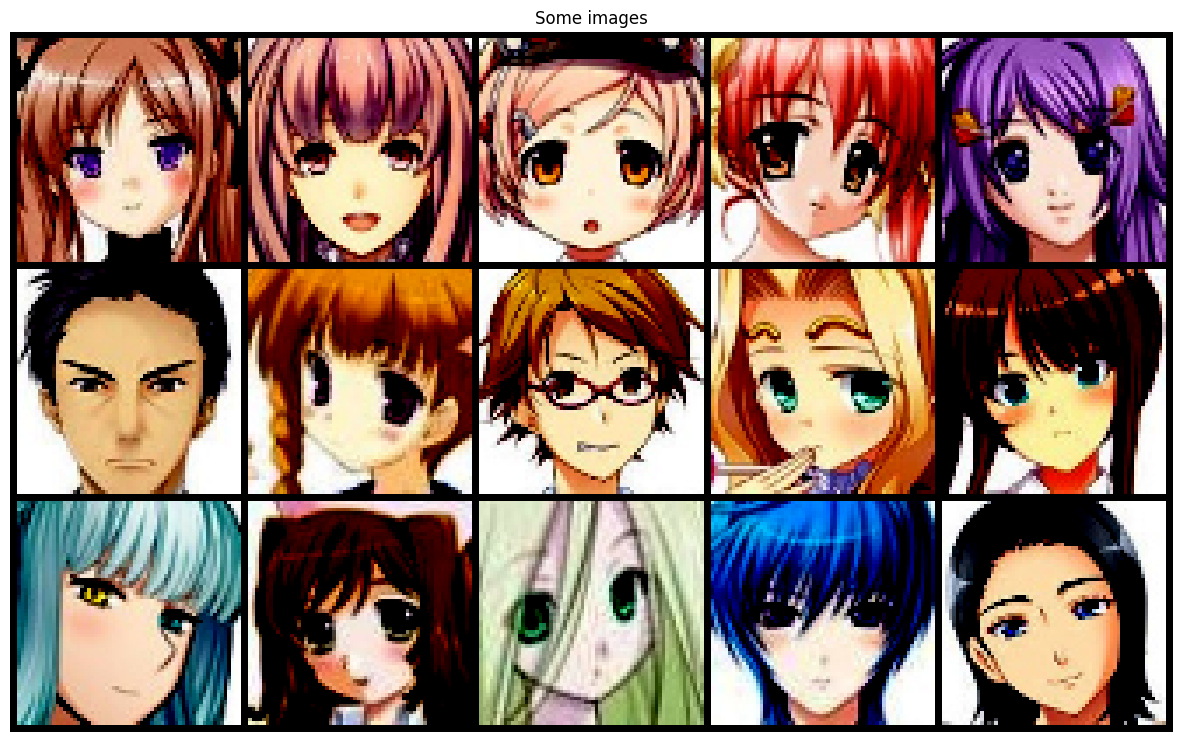

In [5]:
# Show some images
img_list = []
for index, images in enumerate(train_loader):
    # if index == 20:
    #     break
    # img_list.append(images)
    break

img = make_grid(images[:15,...], nrow=5)
grid_np = img.numpy().transpose(1, 2, 0)
# Plot
plt.figure(figsize=(15, 10))
plt.imshow(grid_np)
plt.axis("off")
plt.title("Some images")
plt.show()

----------------------
# Creation of the model

## Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=4*4*256):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(),
        )
        self.xavier_init(self.fc1)

        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.xavier_init(self.conv1)

        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.xavier_init(self.conv2)

        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.xavier_init(self.conv3)

        self.conv_out = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
        self.xavier_init(self.conv_out)


    def xavier_init(self, layer):
        if isinstance(layer, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform(layer.weight)


    def forward(self, x):
        x = self.fc1(x)
        x = x.view((-1, 256, 4, 4,))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv_out(x)
        return x


# Instance the model
generator = Generator()
# summary(generator.to(device), input_size=(1, 100))
generator

Generator(
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_out): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)

**Testing Generator**

In [ ]:
generator.eval()
noise = torch.rand([1, 100])
with torch.no_grad():
    generated_image = generator(noise)

img = np.transpose(generated_image[0], (1, 2, 0))
print(f"Generated shape: {img.shape}")
# plt.imshow(img*255*100)
# plt.show()

px.imshow(img).show()
generator.train()


## Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=3, output_dim=32):
        super().__init__()

        self.in_dim = input_dim
        self.out_dim = output_dim

        # Definition of the model ================
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, 3, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        # self.xavier_init(self.conv1)

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25)
        )
        # self.xavier_init(self.conv2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0,3)
        )
        # self.xavier_init(self.conv3)

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        # self.xavier_init(self.conv4)

        self.out_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*9*9, 1),
            nn.Sigmoid()
        )


    def xavier_init(self, layer):
        if isinstance(layer, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform(layer.weight)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out_layer(x)
        return x


# Instance of the model
discriminator = Discriminator()
summary(discriminator.to(device), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 33, 33]             896
       BatchNorm2d-2           [-1, 32, 33, 33]              64
         LeakyReLU-3           [-1, 32, 33, 33]               0
           Dropout-4           [-1, 32, 33, 33]               0
            Conv2d-5           [-1, 64, 17, 17]          18,496
       BatchNorm2d-6           [-1, 64, 17, 17]             128
         LeakyReLU-7           [-1, 64, 17, 17]               0
           Dropout-8           [-1, 64, 17, 17]               0
            Conv2d-9            [-1, 128, 9, 9]          73,856
      BatchNorm2d-10            [-1, 128, 9, 9]             256
        LeakyReLU-11            [-1, 128, 9, 9]               0
          Dropout-12            [-1, 128, 9, 9]               0
           Conv2d-13            [-1, 256, 9, 9]         295,168
      BatchNorm2d-14            [-1, 25

**Testing Discriminator**

In [8]:
output = discriminator.cpu()(generated_image)
print(output)

NameError: name 'generated_image' is not defined

-------------

# Training

In [8]:
# Preparing saving folder and training parameters
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "dc_gan_rgb_ckpt")

# Training parameters
epochs = 85
noise_dim = 100
num_examples_to_generate = 16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


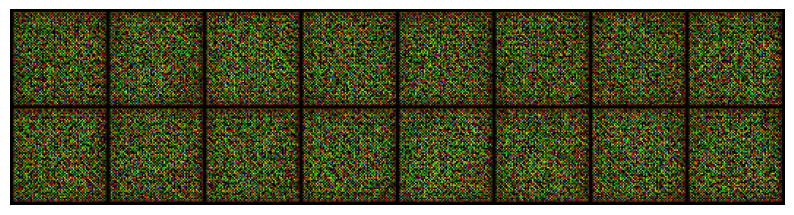

  0%|          | 0/85 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 5, batch: 496 GenLoss:   6.657566, DiscLoss:   0.079170


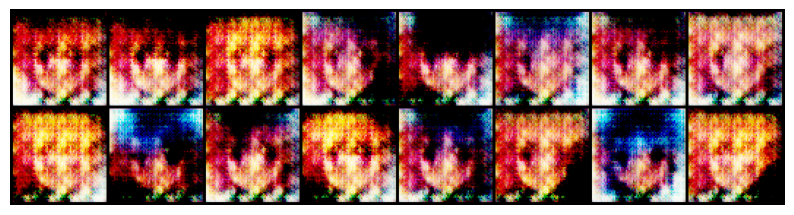

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10, batch: 496 GenLoss:   6.956897, DiscLoss:   0.071505


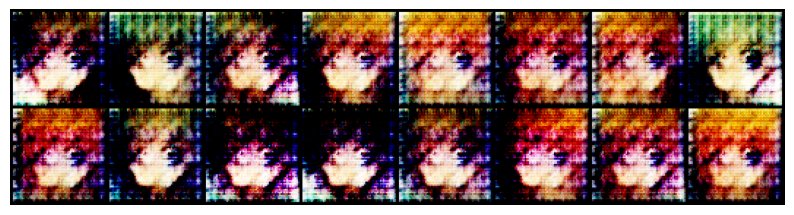

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 15, batch: 496 GenLoss:   7.762625, DiscLoss:   0.049058


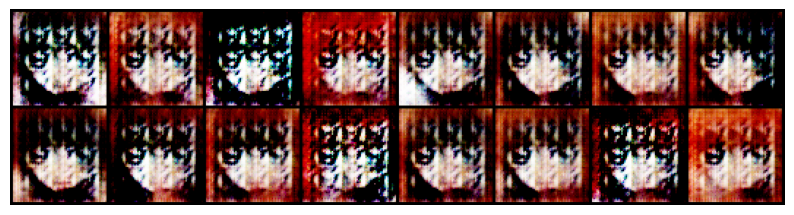

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 20, batch: 496 GenLoss:   8.189554, DiscLoss:   0.045139


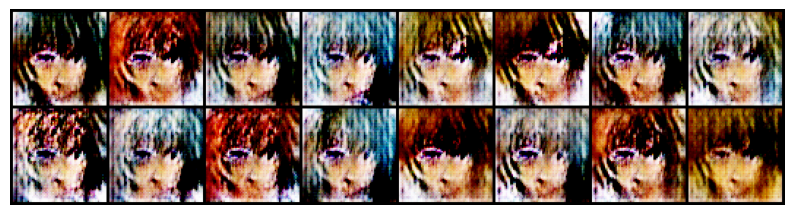

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 25, batch: 496 GenLoss:   8.760549, DiscLoss:   0.031416


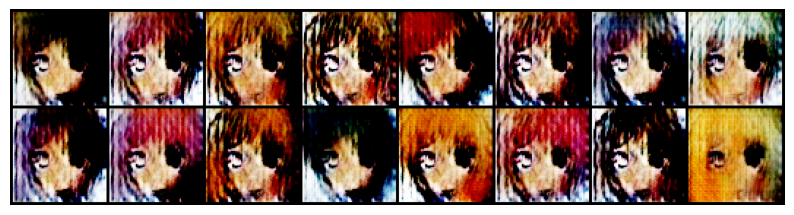

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 30, batch: 496 GenLoss:   9.532153, DiscLoss:   0.024721


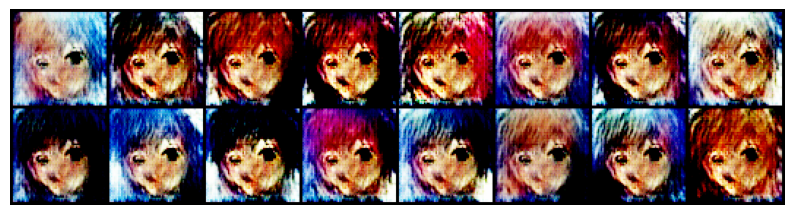

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 35, batch: 496 GenLoss:  10.068389, DiscLoss:   0.020222


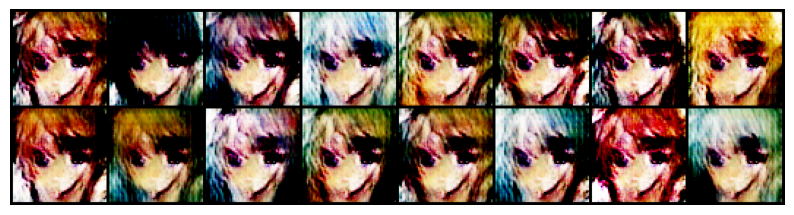

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 40, batch: 496 GenLoss:  10.284146, DiscLoss:   0.019837


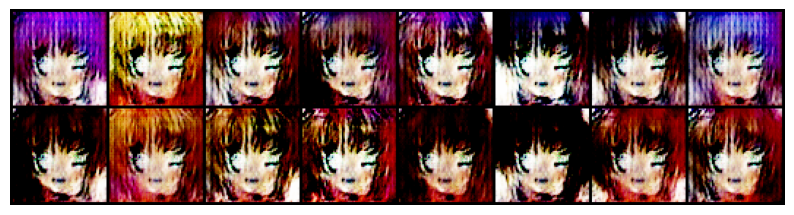

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 45, batch: 496 GenLoss:  10.435333, DiscLoss:   0.016505


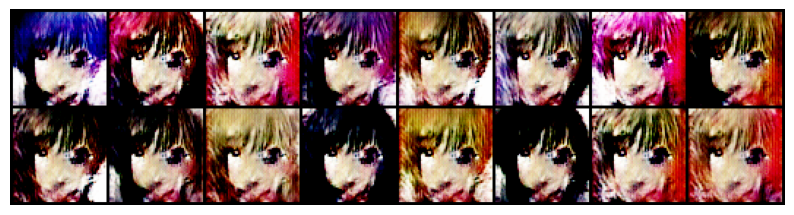

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 50, batch: 496 GenLoss:  11.329391, DiscLoss:   0.014317


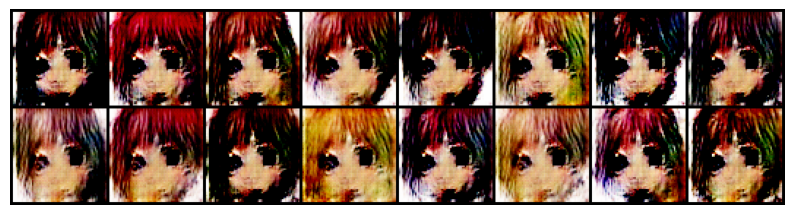

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 55, batch: 496 GenLoss:  11.280509, DiscLoss:   0.013673


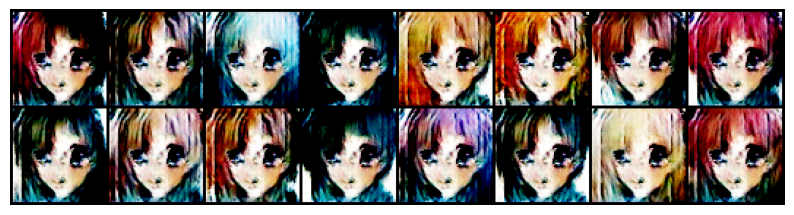

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 60, batch: 496 GenLoss:  11.332545, DiscLoss:   0.014480


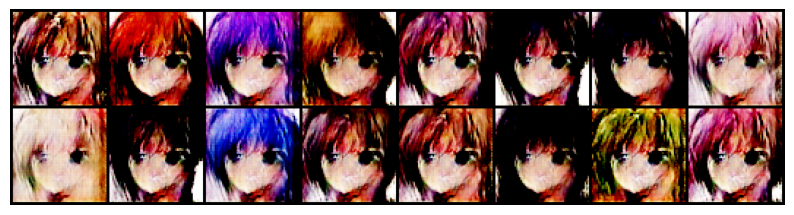

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 65, batch: 496 GenLoss:  11.621552, DiscLoss:   0.015079


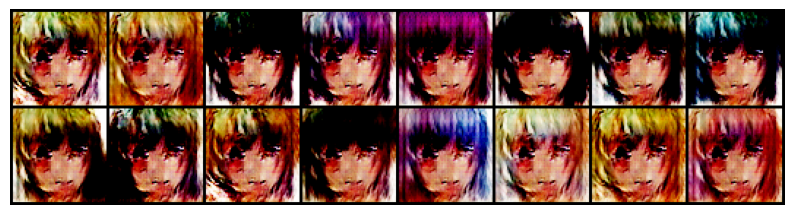

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 70, batch: 496 GenLoss:  12.558738, DiscLoss:   0.014704


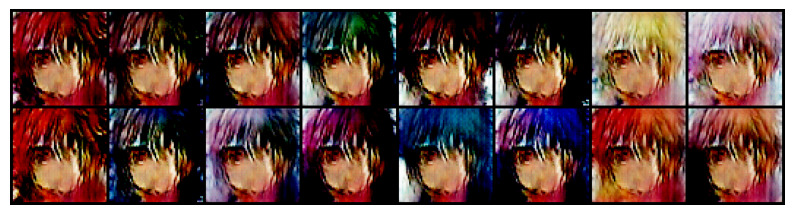

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 75, batch: 496 GenLoss:  12.459642, DiscLoss:   0.009678


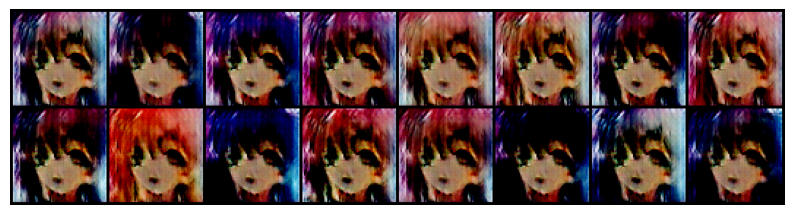

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 80, batch: 496 GenLoss:  12.700613, DiscLoss:   0.008651


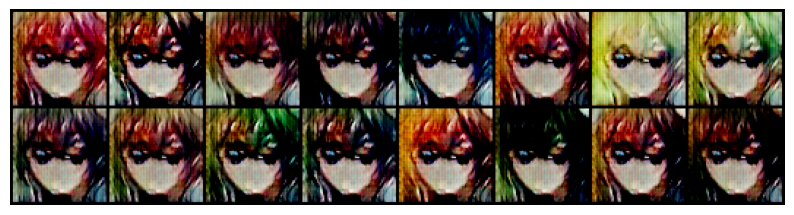

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 85, batch: 496 GenLoss:  13.895711, DiscLoss:   0.008308


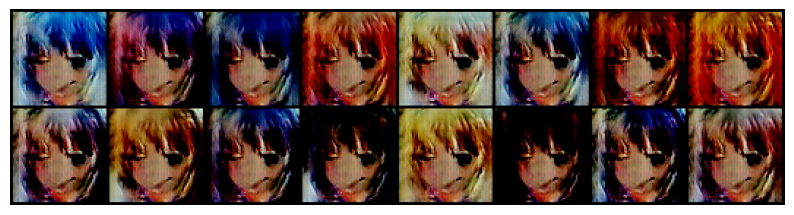

Required time: 2625.3359863758087


In [9]:
# Defining our training function
def training(Generator,
             Discriminator,
             train_loader,
             learning_rate=0.001,
             epochs=50,
             noise_dim=100,
             generated_tests=16,
             checkpoint_path=False,
             seed=614,
             ):

    def save_model():
        checkpoint_dict = dict(generator_state=generator.state_dict(),
                               discriminator_state=discriminator.state_dict(),
                               generator_optimizer=generator_optimizer.state_dict(),
                               discriminator_optimizer=discriminator_optimizer.state_dict(),
                               )
        torch.save(checkpoint_dict, f"{checkpoint_path}_{epoch}.pth")
    # Finish save_model function==================


    def plot_test():
        # Testing process
        noise = torch.randn([generated_tests, noise_dim])
        generated_images = Generator(noise.to(device))

        with torch.no_grad():
            img = make_grid(generated_images.cpu(), nrow=8)

        plt.figure(figsize=(10, 15))
        plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
        plt.axis("off")
        plt.show()


    # Init configs ======================
    # Both will use the same optimizer and both will share the criterion.
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    # Trackers
    gene_losses_list = []
    disc_losses_list = []

    # Setting the seed and time
    torch.manual_seed(seed)
    toc = time()

    # Check the images at the beggining of training
    plot_test()


    for epoch in tqdm_notebook(range(epochs)):
        # Training
        gene_total_loss = 0
        disc_total_loss = 0

        for i, X_train in tqdm_notebook(enumerate(train_loader)):
            # Obtaining the data for trqaining
            real_images = X_train.to(device)
            real_labels = torch.ones(real_images.shape[0], 1).to(device) # All 1 with the shape of real_images
            fake_labels = torch.zeros(real_images.shape[0], 1).to(device) # All 0's with shape of real_images

            # Generator training =======
            # Generating the random noise
            noise = torch.randn([real_images.shape[0], noise_dim]).to(device)
            fake_images = Generator(noise)
            gen_loss = criterion(discriminator(fake_images), real_labels)


            generator_optimizer.zero_grad()
            gen_loss.backward()
            generator_optimizer.step()

            # Discriminator training ======
            real_output = Discriminator(real_images)
            fake_output = Discriminator(fake_images.detach())
            real_loss = criterion(real_output, real_labels)
            fake_loss = criterion(fake_output, fake_labels)
            disc_loss = real_loss + fake_loss

            discriminator_optimizer.zero_grad()
            disc_loss.backward()
            discriminator_optimizer.step()

            # Track of the data
            gene_total_loss += gen_loss.item()
            disc_total_loss += disc_loss.item()

        gene_total_loss /= len(train_loader)
        disc_total_loss /= len(train_loader)

        gene_losses_list.append(gene_total_loss)
        disc_losses_list.append(disc_total_loss)


        if (epoch+1) % 5 == 0:
            print(f"Epoch: {epoch+1}, batch: {i} GenLoss: {gene_total_loss:10.6f}, DiscLoss: {disc_total_loss:10.6f}")
            save_model()
            plot_test()


    epoch = "end"
    save_model()
    print(f"Required time: {time() - toc}")

    return gene_losses_list, disc_losses_list


# Training =============================================
gen_loss, disc_loss = training(generator.to(device),
                               discriminator.to(device),
                               train_loader,
                               0.0001, # 0.002,
                               epochs,
                               noise_dim,
                               generated_tests=16,
                               checkpoint_path=checkpoint_path,
                               )

In [11]:
torch.save(dict(generator=generator,
                discriminator=discriminator), checkpoint_path+"end.pt")

C:\Users\luisx\pythonvenv\base\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping

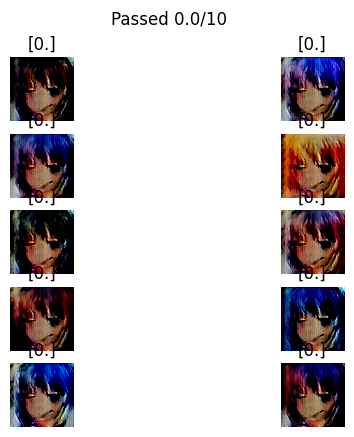

In [10]:
generator.eval()
noise = torch.randn([10, noise_dim])
generated_images = generator(noise.to(device))
labels = discriminator(generated_images)
scores = [np.round(x.detach().cpu().numpy()) for x in labels]

with torch.no_grad():
    for i in range(10):
        plt.subplot(5, 2, i+1)
        plt.title(scores[i])
        plt.imshow(np.transpose(generated_images[i].cpu().numpy(), (1, 2, 0)), cmap="gray")
        plt.axis("off")

    plt.suptitle(f"Passed {sum(scores)[0]}/{len(scores)}")
    plt.show()

In [ ]:
px.line(dict(gen_loss=gen_loss, disc_loss=disc_loss)).show()

In [ ]:
px.line(disc_loss).show()


----------------------------

# Loading the model again

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=4*4*256):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(),
        )
        self.xavier_init(self.fc1)

        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.xavier_init(self.conv1)

        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.xavier_init(self.conv2)

        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.xavier_init(self.conv3)

        self.conv_out = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
        self.xavier_init(self.conv_out)


    def xavier_init(self, layer):
        if isinstance(layer, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform(layer.weight)


    def forward(self, x):
        x = self.fc1(x)
        x = x.view((-1, 256, 4, 4,))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv_out(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, input_dim=3, output_dim=32):
        super().__init__()

        self.in_dim = input_dim
        self.out_dim = output_dim

        # Definition of the model ================
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, 3, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.xavier_init(self.conv1)

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25)
        )
        self.xavier_init(self.conv2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0,3)
        )
        self.xavier_init(self.conv3)

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.xavier_init(self.conv4)

        self.out_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*9*9, 1),
            nn.Sigmoid()
        )


    def xavier_init(self, layer):
        if isinstance(layer, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform(layer.weight)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out_layer(x)
        return x


In [ ]:
model = torch.load("./checkpoints/dc_gan_rgb_ckptend.pt")
generator = model["generator"]
discriminator = model["discriminator"]

In [ ]:
noise_dim = 100
generator.eval()
noise = torch.randn([10, noise_dim])
generated_images = generator(noise.to(device))
labels = discriminator(generated_images)
scores = [np.round(x.detach().cpu().numpy()) for x in labels]

with torch.no_grad():
    for i in range(10):
        plt.subplot(5, 2, i+1)
        plt.title(scores[i])
        plt.imshow(np.transpose(generated_images[i].cpu().numpy(), (1, 2, 0)), cmap="gray")
        plt.axis("off")

    plt.suptitle(f"Passed {sum(scores)[0]}/{len(scores)}")
    plt.show()